# Import Libraries


In [40]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import (
    auc,
    roc_curve,
)
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from config import models
from utils import fine_tune, flatten_datasets, augment_images

# Prepare Training and Testing Data


In [2]:
flag = 2

base_model = models[flag]["base_model"]
model_name = models[flag]["model_name"]
num_layers_to_freeze = models[flag]["num_layers_to_freeze"]
config = models[flag]["config"]

In [3]:
data_dir = "dataset/2-cropped"
class_names = os.listdir(data_dir)

train_set, test_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    seed=config["seed_value"],
    image_size=config["img_shape"],
    batch_size=config["batch_size"],
    label_mode="binary",
    subset="both",
)

train_images, train_labels = flatten_datasets(train_set)
test_images, test_labels = flatten_datasets(test_set)

Found 447 files belonging to 2 classes.
Using 358 files for training.
Using 89 files for validation.


In [4]:
# get number of images per class in the training set
class_counts = np.unique(test_labels, return_counts=True)[1]

class_counts

array([80,  9])

# Defining the Base Model

This project will be using EfficientNetV2-B0 and MobileNetV3-Small. We can easily get this from the TensorFlow API. Let's set a `flag` variable so we can easily set which model we want to test with.


# Predicting with the Model


In [5]:
model = fine_tune(base_model, config, num_layers_to_freeze)

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=config["seed_value"])

# get number of images per class in the training set and valid set per fold
for i, (train_idx, valid_idx) in enumerate(
    cv.split(train_images, np.argmax(train_labels, axis=1))
):
    healthy_train = np.sum(train_labels[train_idx] == 0)
    unhealthy_train = np.sum(train_labels[train_idx] == 1)

    healthy_valid = np.sum(train_labels[valid_idx] == 0)
    unhealthy_valid = np.sum(train_labels[valid_idx] == 1)

    print(f"\nFold {i + 1}")
    print(f"Train: {healthy_train} healthy, {unhealthy_train} unhealthy")
    print(f"Valid: {healthy_valid} healthy, {unhealthy_valid} unhealthy")


Fold 1
Train: 264 healthy, 22 unhealthy
Valid: 67 healthy, 5 unhealthy

Fold 2
Train: 263 healthy, 23 unhealthy
Valid: 68 healthy, 4 unhealthy

Fold 3
Train: 265 healthy, 21 unhealthy
Valid: 66 healthy, 6 unhealthy

Fold 4
Train: 268 healthy, 19 unhealthy
Valid: 63 healthy, 8 unhealthy

Fold 5
Train: 264 healthy, 23 unhealthy
Valid: 67 healthy, 4 unhealthy


In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=config["seed_value"])

train_tprs = []
train_aucs = []

valid_tprs = []
valid_aucs = []

test_tprs = []
test_aucs = []

test_f1_scores = []
test_fnrs = []

mean_fpr = np.linspace(0, 1, 100)

# For Confusion Matrix
predicted_targets = np.array([])
actual_targets = np.array([])

# Create a new model instance and load model weights
checkpoints_path = f"checkpoints/{model_name}/fold_{3}"
latest_checkpoint = tf.train.latest_checkpoint(checkpoints_path)
model.load_weights(latest_checkpoint)

# Loop over the dataset to create separate folds
for i, (train_idx, valid_idx) in enumerate(
    cv.split(train_images, np.argmax(train_labels, axis=1))
):
    print(f"\nFold {i + 1}")
    # Get the training and validation data
    X_train, X_valid = train_images[train_idx, :], train_images[valid_idx, :]
    y_train, y_valid = train_labels[train_idx], train_labels[valid_idx]

    # Augment ONLY training data
    # X_train, y_train = augment_images(X_train, y_train, 5)
    y_train, y_valid = y_train.flatten(), y_valid.flatten()

    # get number of healthy and wssv in training set
    train_counts = np.unique(y_train, return_counts=True)[1]

    # get number of healthy and wssv in valid set
    valid_counts = np.unique(y_valid, return_counts=True)[1]

    print(f"Training set: {train_counts}")
    print(f"Validation set: {valid_counts}")

    # Predict training data
    y_train_preds = model.predict(X_train).flatten()

    fpr, tpr, _ = roc_curve(y_train, y_train_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)

    train_tprs.append(np.interp(mean_fpr, fpr, tpr))
    train_aucs.append(roc_auc)

    # Predict validation data
    y_valid_preds = model.predict(X_valid).flatten()
    y_valid_preds = tf.nn.sigmoid(y_valid_preds).numpy()

    fpr, tpr, _ = roc_curve(y_valid, y_valid_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)

    valid_tprs.append(np.interp(mean_fpr, fpr, tpr))
    valid_aucs.append(roc_auc)

    # Predict testing data
    test_preds = model.predict(test_images).flatten()
    test_preds = tf.nn.sigmoid(test_preds).numpy()

    if i == 0:
        predicted_targets = np.append(predicted_targets, test_preds)
        actual_targets = np.append(actual_targets, test_labels)

    test_fpr, test_tpr, _ = roc_curve(test_labels, test_preds, pos_label=1)
    test_auc = auc(test_fpr, test_tpr)

    # Get test_metrics
    test_results = model.evaluate(test_set)
    test_f1_score = test_results[3]
    test_fnr = test_results[4] / (test_results[4] + test_results[5])

    test_f1_scores.append(test_f1_score)
    test_fnrs.append(test_fnr)

    test_tprs.append(np.interp(mean_fpr, test_fpr, test_tpr))
    test_aucs.append(test_auc)


Fold 1
Training set: [264  22]
Validation set: [67  5]
2/2 [==============================] - 3s 49ms/step - loss: 0.2368 - precision: 0.8571 - recall: 0.6667 - f1_score: 0.8000 - false_negatives: 3.0000 - true_positives: 6.0000 - false_positives: 1.0000 - true_negatives: 79.0000

Fold 2
Training set: [263  23]
Validation set: [68  4]
2/2 [==============================] - 0s 39ms/step - loss: 0.2368 - precision: 0.8571 - recall: 0.6667 - f1_score: 0.8000 - false_negatives: 3.0000 - true_positives: 6.0000 - false_positives: 1.0000 - true_negatives: 79.0000

Fold 3
Training set: [265  21]
Validation set: [66  6]
2/2 [==============================] - 0s 46ms/step - loss: 0.2368 - precision: 0.8571 - recall: 0.6667 - f1_score: 0.8000 - false_negatives: 3.0000 - true_positives: 6.0000 - false_positives: 1.0000 - true_negatives: 79.0000

Fold 4
Training set: [268  19]
Validation set: [63  8]
2/2 [==============================] - 0s 40ms/step - loss: 0.2368 - precision: 0.8571 - recall: 0

Confusion matrix, without normalization


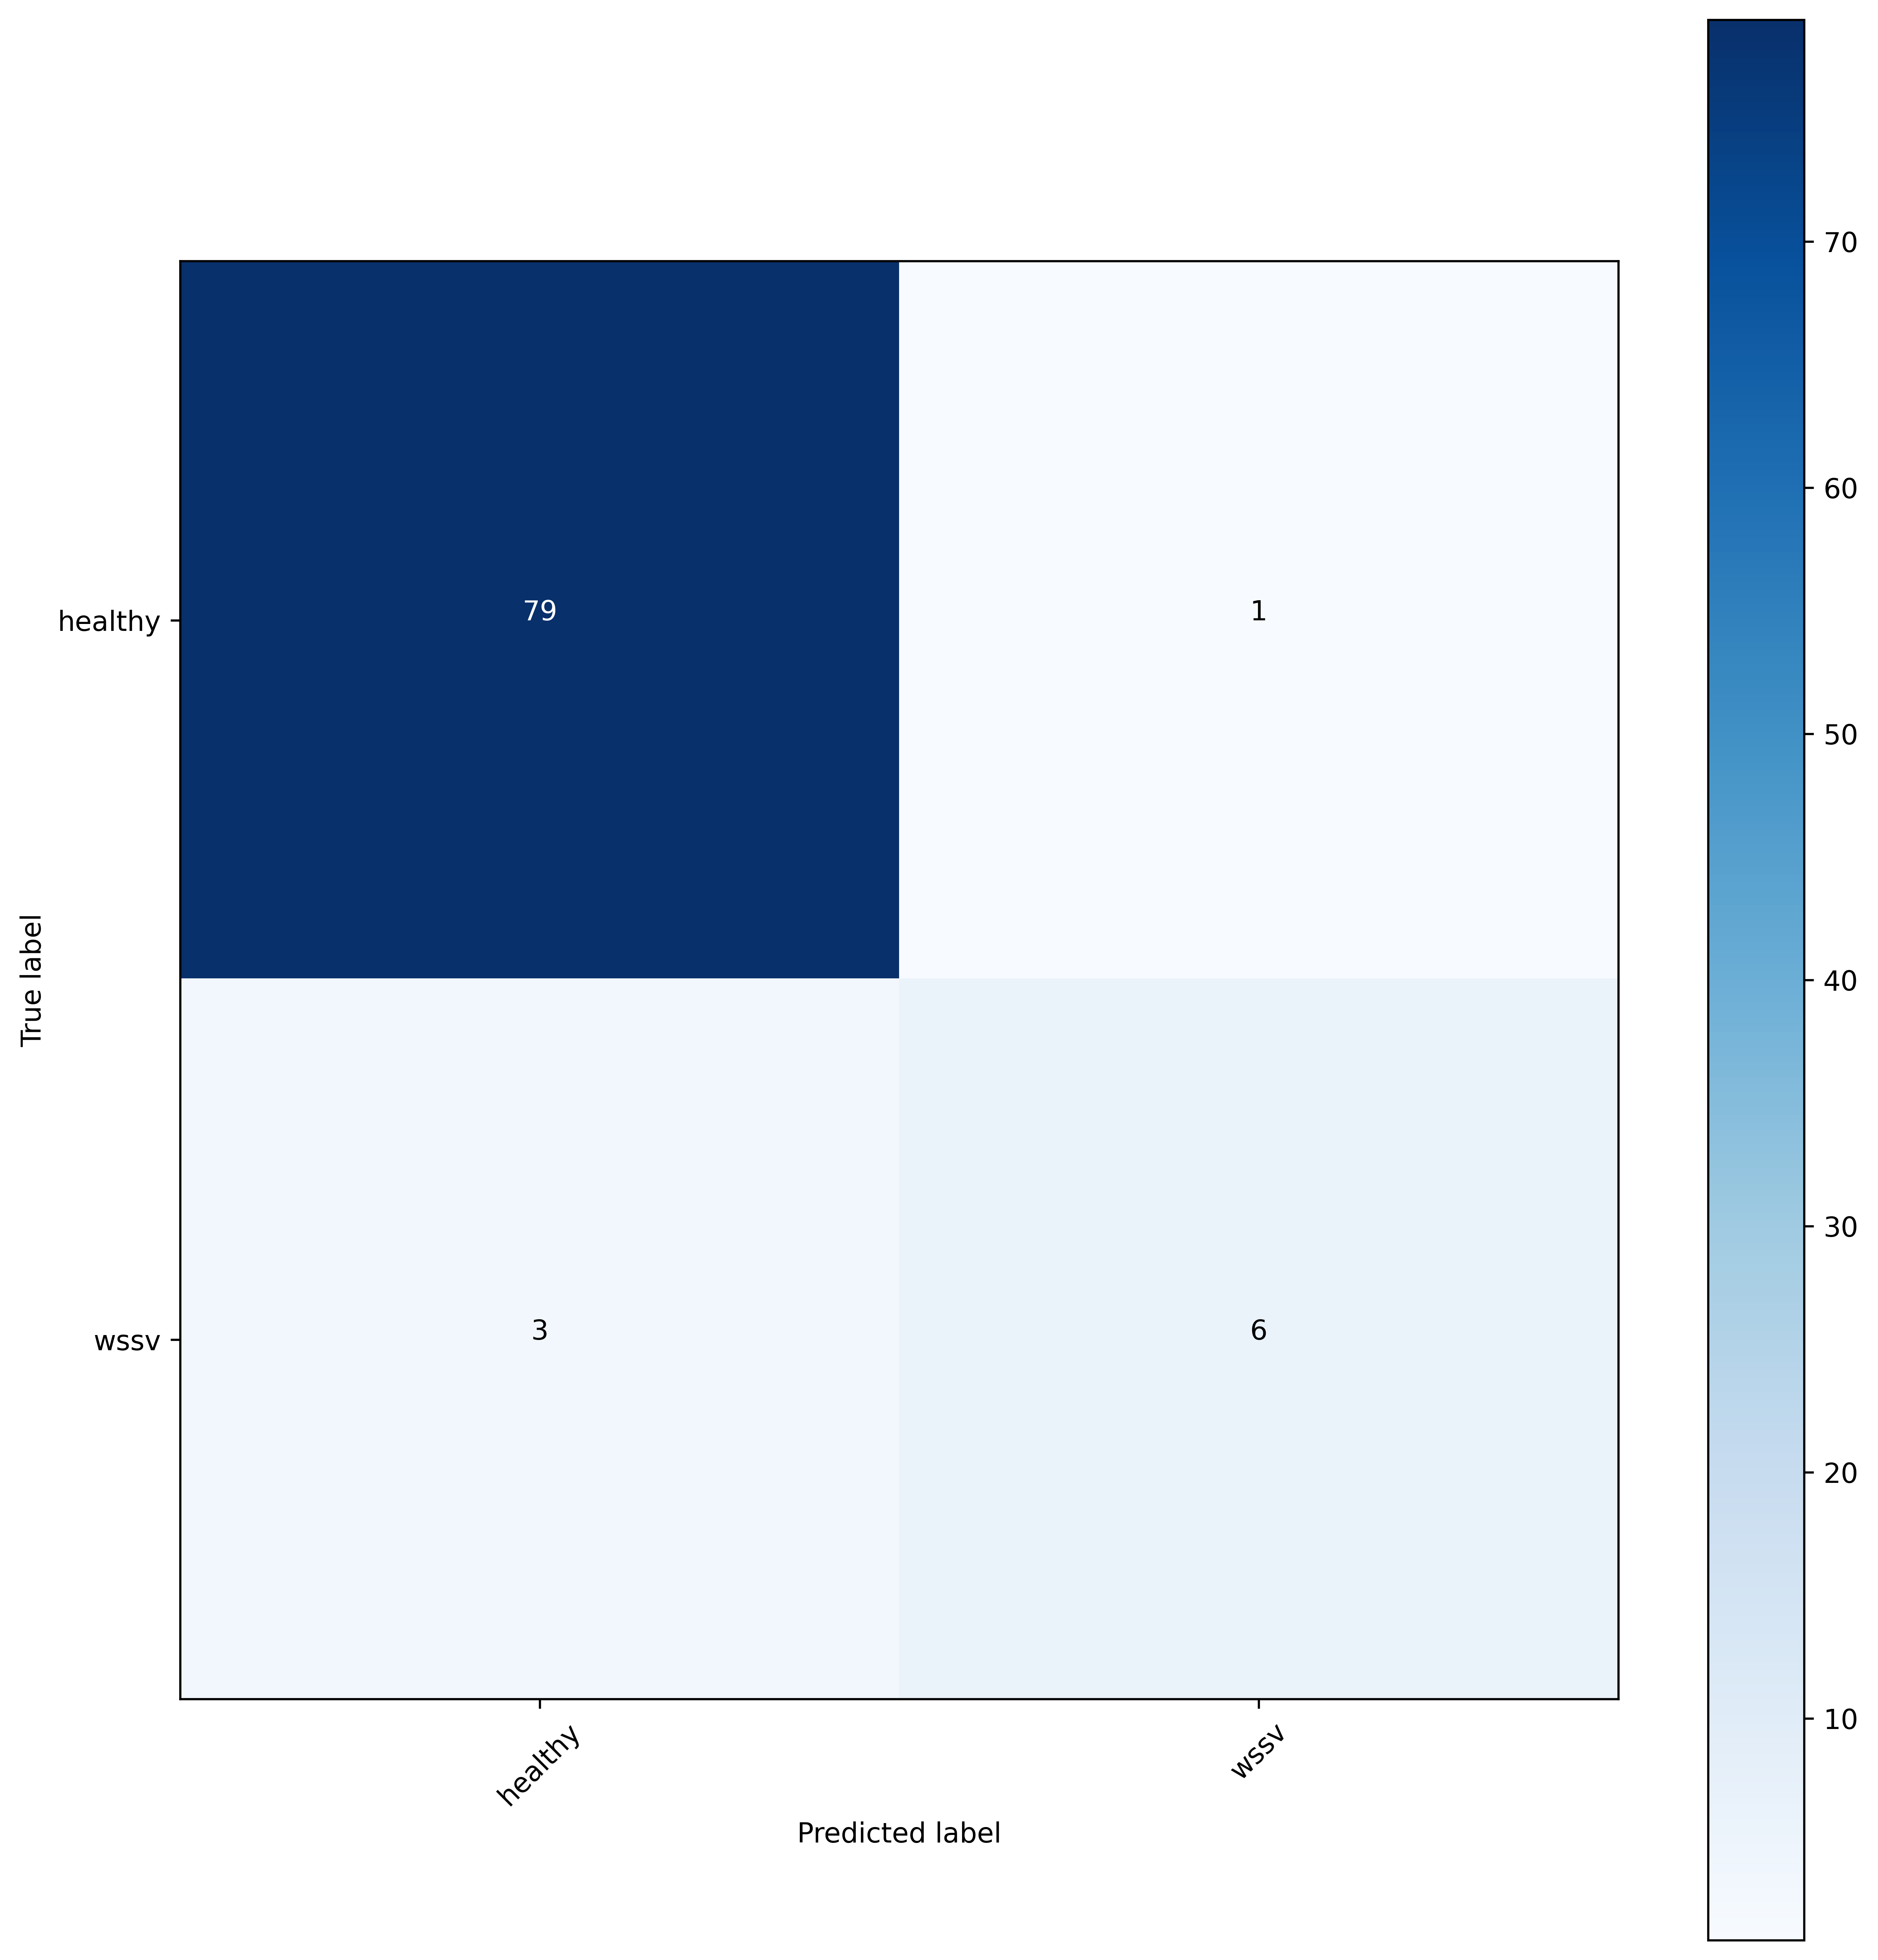

In [8]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(10, 10), dpi=600)
    generate_confusion_matrix(cnf_matrix, classes=class_names)
    plt.show()


def generate_confusion_matrix(
    cnf_matrix, classes, normalize=False, title="Confusion matrix"
):
    if normalize:
        cnf_matrix = cnf_matrix.astype("float") / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    plt.imshow(cnf_matrix, interpolation="nearest", cmap=plt.get_cmap("Blues"))
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cnf_matrix.max() / 2.0

    for i, j in itertools.product(
        range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])
    ):
        plt.text(
            j,
            i,
            format(cnf_matrix[i, j], fmt),
            horizontalalignment="center",
            color="white" if cnf_matrix[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    return cnf_matrix


predicted_targets = np.where(predicted_targets > 0.5, 1, 0)
plot_confusion_matrix(predicted_targets, actual_targets)

In [9]:
plt.rcParams["font.size"] = 20
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.titlepad"] = 15
fig, ax = plt.subplots(figsize=(15, 15), dpi=600)

# train_tprs[np.isnan(train_tprs)] = 0

train_mean_roc_auc = np.mean(train_aucs)
train_mean_tpr = np.mean(train_tprs, axis=0)
train_mean_tpr[0] = 0.0
plt.plot(
    mean_fpr,
    train_mean_tpr,
    color="C0",
    label=r"Train Mean ROC (AUC = %0.2f )" % (train_mean_roc_auc),
    lw=2,
    alpha=1,
)

valid_mean_roc_auc = np.mean(valid_aucs)
valid_mean_tpr = np.mean(valid_tprs, axis=0)
valid_mean_tpr[0] = 0.0
plt.plot(
    mean_fpr,
    valid_mean_tpr,
    color="C1",
    label=r"Valid Mean ROC (AUC = %0.2f )" % (valid_mean_roc_auc),
    lw=2,
    alpha=1,
)

test_mean_roc_auc = np.mean(test_aucs)
test_mean_tpr = np.mean(test_tprs, axis=0)
test_mean_tpr[0] = 0.0

plt.plot(
    mean_fpr,
    test_mean_tpr,
    color="C2",
    label=r"Test Mean ROC (AUC = %0.2f )" % (test_mean_roc_auc),
    lw=2,
    alpha=1,
)
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="C4")
plt.xlabel("False Positive Rate", fontsize=22)
plt.ylabel("True Positive Rate", fontsize=22)
plt.legend(loc="lower right")
plt.grid(linestyle="dotted", lw=2)

plt.show()

In [10]:
# Read all folds
fold_1 = pd.read_csv(f"results/{model_name}/fold_1.csv")
fold_2 = pd.read_csv(f"results/{model_name}/fold_2.csv")
fold_3 = pd.read_csv(f"results/{model_name}/fold_3.csv")
fold_4 = pd.read_csv(f"results/{model_name}/fold_4.csv")
fold_5 = pd.read_csv(f"results/{model_name}/fold_5.csv")

In [11]:
def get_average_metric(model_name, metric):
    fold_1 = pd.read_csv(f"results/{model_name}/fold_1.csv")
    fold_2 = pd.read_csv(f"results/{model_name}/fold_2.csv")
    fold_3 = pd.read_csv(f"results/{model_name}/fold_3.csv")
    fold_4 = pd.read_csv(f"results/{model_name}/fold_4.csv")
    fold_5 = pd.read_csv(f"results/{model_name}/fold_5.csv")

    # get the average curve
    average_metric = (
        fold_1[metric]
        + fold_2[metric]
        + fold_3[metric]
        + fold_4[metric]
        + fold_5[metric]
    ) / 5

    return average_metric


def get_average_loss(model_name, path):
    fold_1 = pd.read_csv(f"{path}/{model_name}/fold_1.csv").loc[:, ["loss", "val_loss"]]
    fold_2 = pd.read_csv(f"{path}/{model_name}/fold_2.csv").loc[:, ["loss", "val_loss"]]
    fold_3 = pd.read_csv(f"{path}/{model_name}/fold_3.csv").loc[:, ["loss", "val_loss"]]
    fold_4 = pd.read_csv(f"{path}/{model_name}/fold_4.csv").loc[:, ["loss", "val_loss"]]
    fold_5 = pd.read_csv(f"{path}/{model_name}/fold_5.csv").loc[:, ["loss", "val_loss"]]

    # fill missing values until 200 epochs
    # get max column length from all folds
    max_length = max(
        len(fold_1["loss"]),
        len(fold_2["loss"]),
        len(fold_3["loss"]),
        len(fold_4["loss"]),
        len(fold_5["loss"]),
    )
    # get last value from max column length fold
    last_value = fold_1["loss"].iloc[-1]

    fold_1 = fold_1.reindex(range(200), fill_value=0)
    fold_2 = fold_2.reindex(range(200), fill_value=0)
    fold_3 = fold_3.reindex(range(200), fill_value=0)
    fold_4 = fold_4.reindex(range(200), fill_value=0)
    fold_5 = fold_5.reindex(range(200), fill_value=0)

    # get the average curve
    average_loss = (
        fold_1["loss"]
        + fold_2["loss"]
        + fold_3["loss"]
        + fold_4["loss"]
        + fold_5["loss"]
    ) / 5

    average_val_loss = (
        fold_1["val_loss"]
        + fold_2["val_loss"]
        + fold_3["val_loss"]
        + fold_4["val_loss"]
        + fold_5["val_loss"]
    ) / 5

    return average_loss, average_val_loss

In [12]:
mobile_loss, mobile_val_loss = get_average_loss(
    "Mobilenetv3small", "results/best_results"
)
efficient_loss, efficient_val_loss = get_average_loss(
    "efficientnetv2-b0", "results/best_results"
)

In [44]:
fig, axs = plt.subplots(2, 1, figsize=(16, 16), dpi=600)

# Plotting for mobile_loss and mobile_val_loss
axs[0].plot(mobile_loss, color="C0", label="Training")
axs[0].plot(mobile_val_loss, color="C1", label="Validation")
axs[0].set_ylim(0, 1)
axs[0].set_xlim(0, 174)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Cross-Entropy Loss")
axs[0].legend(loc="upper right")


# Plotting for efficient_loss and efficient_val_loss
axs[1].plot(efficient_loss, color="C0", label="Training")
axs[1].plot(efficient_val_loss, color="C1", label="Validation")
axs[1].set_ylim(0, 1)
axs[1].set_xlim(0, 199)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Cross-Entropy Loss")
axs[1].legend(loc="upper right")


plt.tight_layout()
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

In [15]:
def create_fnr(df):
    df["fnr"] = df.apply(
        lambda row: row["false_negatives"]
        / (row["true_positives"] + row["false_negatives"]),
        axis=1,
    )

    df["val_fnr"] = df.apply(
        lambda row: row["val_false_negatives"]
        / (row["val_true_positives"] + row["val_false_negatives"]),
        axis=1,
    )

    return df


fold_1 = create_fnr(fold_1)
fold_2 = create_fnr(fold_2)
fold_3 = create_fnr(fold_3)
fold_4 = create_fnr(fold_4)
fold_5 = create_fnr(fold_5)


def create_average_std(fold_1, fold_2, fold_3, fold_4, fold_5, metric):
    if metric == "fnr" or metric == "val_fnr":
        average_metric = (
            np.min(fold_1[metric])
            + np.min(fold_2[metric])
            + np.min(fold_3[metric])
            + np.min(fold_4[metric])
            + np.min(fold_5[metric])
        ) / 5

        std_f1_score = np.std(
            [
                np.min(fold_1[metric]),
                np.min(fold_2[metric]),
                np.min(fold_3[metric]),
                np.min(fold_4[metric]),
                np.min(fold_5[metric]),
            ]
        )
    else:
        average_metric = (
            np.max(fold_1[metric])
            + np.max(fold_2[metric])
            + np.max(fold_3[metric])
            + np.max(fold_4[metric])
            + np.max(fold_5[metric])
        ) / 5

        std_f1_score = np.std(
            [
                np.max(fold_1[metric]),
                np.max(fold_2[metric]),
                np.max(fold_3[metric]),
                np.max(fold_4[metric]),
                np.max(fold_5[metric]),
            ]
        )

    return average_metric, std_f1_score


def get_average_metric(metric):
    average = np.mean(metric)
    std_metric = np.std(metric)

    return average, std_metric


train_f1_score, std_train_f1_score = create_average_std(
    fold_1, fold_2, fold_3, fold_4, fold_5, "f1_score"
)
train_auc, std_train_auc = get_average_metric(train_aucs)
train_fnr, std_train_fnr = create_average_std(
    fold_1, fold_2, fold_3, fold_4, fold_5, "fnr"
)

val_f1_score, std_val_f1_score = create_average_std(
    fold_1, fold_2, fold_3, fold_4, fold_5, "val_f1_score"
)
val_auc, std_val_auc = get_average_metric(valid_aucs)
val_fnr, std_val_fnr = create_average_std(
    fold_1, fold_2, fold_3, fold_4, fold_5, "val_fnr"
)

test_f1_score, std_test_f1_score = get_average_metric(test_f1_scores)
test_auc, std_test_auc = get_average_metric(test_aucs)
test_fnr, std_test_fnr = get_average_metric(test_fnrs)

In [16]:
df = pd.DataFrame(
    {
        "Train": [
            f"{train_f1_score:.4f} ± {std_train_f1_score:.4f}",
            f"{train_auc:.4f} ± {std_train_auc:.4f}",
            f"{train_fnr:.4f} ± {std_train_fnr:.4f}",
        ],
        "Validation": [
            f"{val_f1_score:.4f} ± {std_val_f1_score:.4f}",
            f"{val_auc:.4f} ± {std_val_auc:.4f}",
            f"{val_fnr:.4f} ± {std_val_fnr:.4f}",
        ],
        "Test": [
            f"{test_f1_score:.4f} ± {std_test_f1_score:.4f}",
            f"{test_auc:.4f} ± {std_test_auc:.4f}",
            f"{test_fnr:.4f} ± {std_test_fnr:.4f}",
        ],
    },
    index=["F1-Score", "AUC", "FNR"],
)

In [17]:
# save as csv
df.to_csv(f"results/{model_name}/average_metrics.csv")